In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
from sqlalchemy import inspect
inspector = inspect(engine)

for table_name in inspector.get_table_names():
   for column in inspector.get_columns(table_name):
       print("Column: %s" % column['name'], column['type'])

Column: id INTEGER
Column: station TEXT
Column: date TEXT
Column: prcp FLOAT
Column: tobs FLOAT
Column: id INTEGER
Column: station TEXT
Column: name TEXT
Column: latitude FLOAT
Column: longitude FLOAT
Column: elevation FLOAT


In [6]:
from sqlalchemy import MetaData
m = MetaData()
m.reflect(engine)
for table in m.tables.values():
    print(table.name)

measurement
station


In [7]:
 # reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)

In [11]:
pd.read_sql('SELECT * FROM station LIMIT 5', engine)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
pd.read_sql('SELECT * FROM measurement LIMIT 5', engine)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [18]:
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(latest_date[0])

2017-08-23


In [100]:
last_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
first_date = dt.date(last_date.year -1, last_date.month, last_date.day)

last_twelve_months_prcp = session.query(measurement.date,measurement.prcp).filter(measurement.date >= first_date).all()




In [101]:
df = pd.DataFrame(last_twelve_months_prcp, columns=['date','prcp'])

df = df.dropna(how='any').sort_values(['date']).set_index('date')

df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


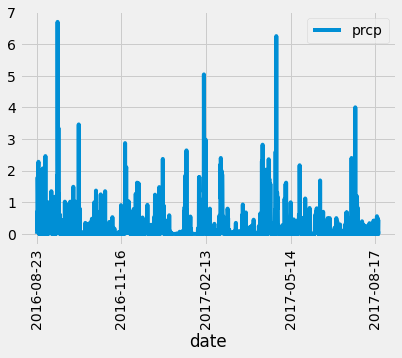

In [102]:
df.plot(rot=90)
plt.show()

In [103]:
print(df.describe())

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [94]:
#STATION ANALYSIS#

In [48]:
total_stations = session.query(station.name).count()

print(total_stations)

9


In [52]:
active_stations = session.query(measurement.station,func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
highest_observations = session.query(measurement.station).group_by(measurement.station).order_by(func.count(measurement.id).desc()).first()

highest_observations

('USC00519281',)

In [92]:
USC00519281_avg = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

In [98]:
print(f'Most active station observed temperatures (min, max, avg): {USC00519281_avg[0]}')

Most active station observed temperatures (min, max, avg): (54.0, 85.0, 71.66378066378067)


In [174]:
print(f'{latest_date[0]}')

2017-08-23


In [125]:
last_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
first_date = dt.date(last_date.year -1, last_date.month, last_date.day)

last_twelve_months_tobs = session.query(measurement.id,measurement.station,measurement.date,measurement.tobs).filter(measurement.date >= first_date).filter(measurement.station == 'USC00519281').all()

In [191]:
df = pd.DataFrame(last_twelve_months_tobs, columns=['id','station','date','tobs'])

df = df.dropna(how='any').sort_values(['tobs']).set_index('date')

df.head()

,id,station,tobs
date,,,
2017-02-02,14771,USC00519281,59.0
2017-02-08,14777,USC00519281,59.0
2017-02-09,14778,USC00519281,59.0
2017-04-30,14858,USC00519281,60.0
2017-02-03,14772,USC00519281,60.0


In [192]:
df.describe()

,id,tobs
count,352.000000,352.000000
mean,14783.500000,73.107955
std,101.757883,4.733315
min,14608.000000,59.000000
25%,14695.750000,70.000000
50%,14783.500000,74.000000
75%,14871.250000,77.000000
max,14959.000000,83.000000


In [193]:
frequency = pd.DataFrame(df['tobs'].groupby([df['tobs']]).count())

In [194]:
frequency.columns = ['count']

frequency.reset_index(inplace=True)

frequency = frequency.set_index('count')



In [206]:
frequency_final = frequency.sort_values('count', ascending=False)

frequency_final.head()

,tobs
count,
39,74.0
33,76.0
33,75.0
31,77.0
22,78.0


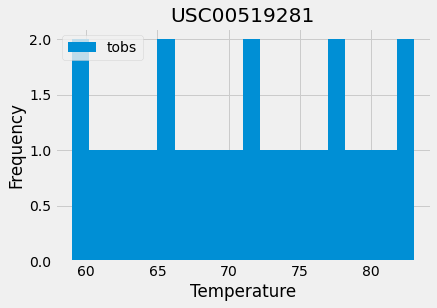

In [214]:
frequency_final.plot.hist(bins=20)

plt.title("USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()

In [ ]:




Design a query to retrieve the last 12 months of temperature observation data (TOBS).


Filter by the station with the highest number of observations.


Query the last 12 months of temperature observation data for this station.


Plot the results as a histogram with bins=12.